In [7]:
%reload_ext autoreload
%autoreload 2

import os
import cv2
import sys
import glob
import json
import time
import click
import random
import logging
import numpy as np
import pandas as pd
import yaml
from PIL import Image
import rasterio
from rasterio.windows import Window
from rasterio.transform import from_bounds
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Any
from dataclasses import dataclass
from tqdm import tqdm
from shapely.geometry import shape, mapping, box, Polygon
from shapely.ops import unary_union

import albumentations as A
from albumentations.pytorch import ToTensorV2

from ship_detector.scripts.train_vit import ViTShipClassifier
from ship_detector.scripts.inference_pipeline import ImageDataset, PipelineConfig, InferencePipeline
from ship_detector.scripts.utils import load_config

In [3]:
inference_config = 'configs/inference.yaml'
vit_checkpoint = 'outputs/checkpoints/vit-epoch=03-val_acc=0.967.ckpt'
vit_config = 'configs/vit.yaml'
unet_checkpoint = 'outputs/unet_experiments/checkpoints/unet-epoch=00-val_iou=1.000.ckpt'
unet_config = 'configs/unet.yaml'
patch_size = 224
overlap = 32
batch_size = 128
confidence_threshold = 0.5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
use_s3 = False
output_format = ['mask', 'geojson']
save_patch_predictions=True

In [8]:
inference_cfg = load_config(inference_config)

In [9]:
inference_cfg.keys()

dict_keys(['image', 'batch', 'output_dir', 'vit_checkpoint', 'vit_config', 'unet_checkpoint', 'unet_config', 'patch_size', 'overlap', 'batch-size', 'confidence_threshold', 'device', 'formats', 'save_patches', 'use_s3', 's3_bucket'])

In [12]:
inference_cfg['image'] is None

True

In [ ]:
inference_cfg

In [3]:
with open(vit_config, 'r') as f:
    vit_config = yaml.safe_load(f)

In [18]:
with open(unet_config, 'r') as f:
    unet_config = yaml.safe_load(f)

In [4]:
model = ViTShipClassifier(vit_config)

2025-09-04 18:41:51,275 - timm.models._builder - INFO - Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.augreg2_in21k_ft_in1k)
2025-09-04 18:41:52,192 - timm.models._hub - INFO - [timm/vit_base_patch16_224.augreg2_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2025-09-04 18:41:52,294 - timm.models._builder - INFO - Missing keys (head.weight, head.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


In [5]:
checkpoint = torch.load(vit_checkpoint, map_location='cpu', weights_only=False)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [6]:
model = model.to(device)
model.eval()

ViTShipClassifier(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
       

In [7]:
vit_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [8]:
def load_image( image_path: str) -> np.ndarray:
    ext = Path(image_path).suffix.lower()
    if ext in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif']:
        image = Image.open(image_path).convert('RGB')
        image = np.array(image)
    else:
        image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def tile_image(config: Dict[str, Any], image: np.ndarray) -> Tuple[List[Dict], Dict]:
    patches = []
    h, w = image.shape[:2]
    
    metadata = {
        'width': w,
        'height': h,
        'channels': image.shape[2] if len(image.shape) > 2 else 1,
        'dtype': str(image.dtype)
    }
    
    stride = config['inference']['patch_size'] - config['inference']['overlap']
    patch_id = 0
    
    for row in range(0, h - config['inference']['patch_size'] + 1, stride):
        for col in range(0, w - config['inference']['patch_size'] + 1, stride):
            patch_data = image[row:row+config['inference']['patch_size'], col:col+config['inference']['patch_size']]
            
            if patch_data.std() < 1.0:
                continue
            
            patches.append({
                'id': patch_id,
                'image': patch_data.copy(),
                'row': row,
                'col': col,
                'coords': (row, col, row+config['inference']['patch_size'], col+config['inference']['patch_size'])
            })
            patch_id += 1
    
    if w % stride != 0 and w > config['inference']['patch_size']:
        col = w - config['inference']['patch_size']
        for row in range(0, h - config['inference']['patch_size'] + 1, stride):
            patch_data = image[row:row+config['inference']['patch_size'], col:col+config['inference']['patch_size']]
            
            if patch_data.std() >= 1.0:
                patches.append({
                    'id': patch_id,
                    'image': patch_data.copy(),
                    'row': row,
                    'col': col,
                    'coords': (row, col, row+config['inference']['patch_size'], col+config['inference']['patch_size'])
                })
                patch_id += 1
    
    if h % stride != 0 and h > config['inference']['patch_size']:
        row = h - config['inference']['patch_size']
        for col in range(0, w - config['inference']['patch_size'] + 1, stride):
            patch_data = image[row:row+config['inference']['patch_size'], col:col+config['inference']['patch_size']]
            
            if patch_data.std() >= 1.0:
                patches.append({
                    'id': patch_id,
                    'image': patch_data.copy(),
                    'row': row,
                    'col': col,
                    'coords': (row, col, row+config['inference']['patch_size'], col+config['inference']['patch_size'])
                })
                patch_id += 1
    
    if w % stride != 0 and h % stride != 0 and w > config['inference']['patch_size'] and h > config['inference']['patch_size']:
        row = h - config['inference']['patch_size']
        col = w - config['inference']['patch_size']
        patch_data = image[row:row+config['inference']['patch_size'], col:col+config['inference']['patch_size']]
        
        if patch_data.std() >= 1.0:
            patches.append({
                'id': patch_id,
                'image': patch_data.copy(),
                'row': row,
                'col': col,
                'coords': (row, col, row+config['inference']['patch_size'], col+config['inference']['patch_size'])
            })
    return patches, metadata

def classify_patches(patches: List[Dict], config: Dict[str, Any], model: ViTShipClassifier, transforms: transforms.Compose) -> np.ndarray:
    if not patches:
        return np.array([])
    
    dataset = ImageDataset(patches, transform=transforms)
    dataloader = DataLoader(
        dataset,
        batch_size=config['inference']['batch_size'],
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )
    
    probabilities = []
    
    with torch.no_grad():
        for batch, indices in tqdm(dataloader, desc='Classifying patches'):
            batch = batch.to(device)
            outputs = model(batch).squeeze()
            
            if outputs.dim() == 0:
                outputs = outputs.unsqueeze(0)
            
            probs = torch.sigmoid(outputs)
            probabilities.extend(probs.cpu().numpy())
            
    return np.array(probabilities)

In [9]:
def process_image(model: ViTShipClassifier, transforms: transforms.Compose, config: Dict[str, Any], image_path: str, output_dir: str) -> Dict:
    start_time = time.time()
    image_name = Path(image_path).stem
    
    image = load_image(image_path)
    patches, metadata = tile_image(config, image)
    
    if not patches:
        return {
            'image': image_name,
            'status': 'no_valid_patches',
            'processing_time': time.time() - start_time
        }
        
    probabilities = classify_patches(patches, config, model, transforms)
    
    ship_indices = np.where(probabilities >= config['inference']['confidence_threshold'])[0]

    if config['inference']['save_patch_predictions']:
        patch_results = pd.DataFrame({
            'patch_id': [p['id'] for p in patches],
            'row': [p['row'] for p in patches],
            'col': [p['col'] for p in patches],
            'probability': probabilities,
            'has_ship': probabilities >= config['inference']['confidence_threshold']
        })
        patch_results.to_csv(
            os.path.join(output_dir, f"{image_name}_patches.csv"),
            index=False
        )
    return {
        'image': image_name,
        'status': 'processed',
        'processing_time': time.time() - start_time
    }
    
def process_batch(model: ViTShipClassifier, transforms: transforms.Compose, config: Dict[str, Any], image_paths: List[str], output_dir: str) -> List[Dict]:
    results = []
    for image_path in tqdm(image_paths, desc="Processing images"):
        try:
            result = process_image(model, transforms, config, image_path, output_dir)
            results.append(result)
        except Exception as e:
            results.append({
                'image': Path(image_path).stem,
                'status': 'error',
                'error': str(e)
            })
    summary_path = os.path.join(output_dir, 'batch_summary.json')
    with open(summary_path, 'w') as f:
        json.dump(results, f, indent=2)
    return results

In [10]:
img_paths = glob.glob('data/airbus-ship-detection/test_v2/*.jpg')


In [11]:
# randomly pick an image path
image_path = random.choice(img_paths)
image_path

'data/airbus-ship-detection/test_v2\\45775b878.jpg'

In [12]:
vit_config['inference']['batch_size']

64

In [13]:
res = process_image(model, vit_transform, vit_config, image_path, 'outputs')

Classifying patches: 100%|██████████| 1/1 [00:37<00:00, 37.35s/it]


In [14]:
res

{'image': '45775b878',
 'status': 'processed',
 'processing_time': 37.41712260246277}

In [22]:
config = PipelineConfig(
    vit_checkpoint=vit_checkpoint,
    vit_config=vit_config,
    unet_checkpoint=unet_checkpoint,
    unet_config=unet_config,
    patch_size=patch_size,
    overlap=overlap,
    batch_size=batch_size,
    confidence_threshold=confidence_threshold,
    device=device,
    use_s3=use_s3,
    output_format=output_format,
    save_patch_predictions=save_patch_predictions
)

In [36]:
image = random.choice(img_paths)
image_name = Path(image).stem

In [37]:
image_name

'd7aaa6636'

In [38]:
image

'data/airbus-ship-detection/test_v2\\d7aaa6636.jpg'

In [29]:
pipeline = InferencePipeline(config)

2025-09-04 18:53:49,218 - ship_detector.scripts.inference_pipeline - INFO - Loading models...
2025-09-04 18:53:50,344 - timm.models._builder - INFO - Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.augreg2_in21k_ft_in1k)
2025-09-04 18:53:51,035 - timm.models._hub - INFO - [timm/vit_base_patch16_224.augreg2_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2025-09-04 18:53:51,137 - timm.models._builder - INFO - Missing keys (head.weight, head.bias) discovered while loading pretrained weights. This is expected if model is being adapted.
2025-09-04 18:53:52,331 - scripts.train_unet - INFO - Freezing the entire encoder.
2025-09-04 18:53:52,333 - scripts.train_unet - INFO - Freezing BatchNorm layers in encoder
2025-09-04 18:53:52,337 - scripts.train_unet - INFO - ==================================================
2025-09-04 18:53:52,337 - scripts.train_unet - INFO - Model Parameter Stati

In [42]:
stats = pipeline.process_image(image, 'outputs')

2025-09-04 18:59:50,321 - ship_detector.scripts.inference_pipeline - INFO - Processing d7aaa6636...
2025-09-04 18:59:50,334 - ship_detector.scripts.inference_pipeline - INFO - Loaded image: data/airbus-ship-detection/test_v2\d7aaa6636.jpg - Shape: (768, 768, 3)
2025-09-04 18:59:50,336 - ship_detector.scripts.inference_pipeline - INFO - Tiling image: 768x768 into 224x224 patches
2025-09-04 18:59:50,351 - ship_detector.scripts.inference_pipeline - INFO - Created 9 patches
Classifying patches: 100%|██████████| 1/1 [00:37<00:00, 37.24s/it]
2025-09-04 19:00:27,601 - ship_detector.scripts.inference_pipeline - INFO - Found 0/9 patches with ships
2025-09-04 19:00:27,618 - ship_detector.scripts.inference_pipeline - INFO - Saved mask to outputs\d7aaa6636_mask.png
2025-09-04 19:00:27,621 - ship_detector.scripts.inference_pipeline - INFO - Completed d7aaa6636 in 37.29 seconds
2025-09-04 19:00:27,623 - ship_detector.scripts.inference_pipeline - INFO - Detected 0 ships


In [43]:
stats

{'image': 'd7aaa6636',
 'status': 'success',
 'processing_time': 37.29298496246338,
 'image_size': (768, 768),
 'num_patches': 9,
 'num_ship_patches': 0,
 'num_ships_detected': 0,
 'outputs': {'mask': 'outputs\\d7aaa6636_mask.png'}}

In [39]:
img = cv2.imread(image)

In [40]:
img = Image.fromarray(img)

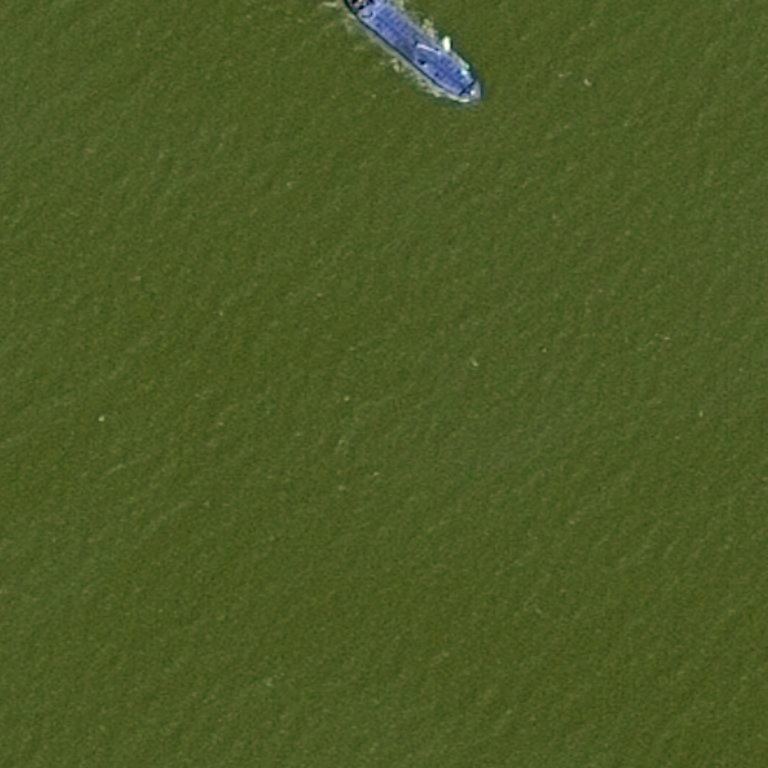

In [41]:
img